In [1]:
from __future__ import annotations
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("Blackjack-v1",sab=True,render_mode="human") #sab: rules from sutton and barto

In [2]:
done = False
observation, info = env.reset()

In [3]:
action = env.action_space.sample()
observation, reward, terminated, truncated,info = env.step(action)

In [4]:
##Agent

class BlackJackAgent:
    def __init__(self, lr, init_eps, eps_decay,fin_eps,gamma=0.95):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = lr
        self.gamma = gamma

        self.eps = init_eps
        self.eps_decay = eps_decay
        self.final_eps = fin_eps

        self.training_error = []

    def get_action(self, obs):
        if np.random.random() < self.eps:
            return env.action_space.sample()
        
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(self, obs, action,reward,terminated,next_obs):
        future_q_val=(not terminated)*np.max(self.q_values[next_obs])
        temporal_diff = (reward + self.gamma*future_q_val-self.q_values[obs][action])
        self.q_values[obs][action] = (self.q_values[obs][action]+self.lr*temporal_diff)
        self.training_error.append(temporal_diff)

    def decay_eps(self):
        self.eps = max(self.final_eps,self.eps-self.eps_decay)
        

In [5]:
lr = 1e-3
n_episodes = 100000
start_eps = 1.0
eps_decay = start_eps/(n_episodes/2)
fin_eps = 0.1

agent = BlackJackAgent(lr,start_eps,eps_decay,fin_eps)



In [6]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done=False
    while not done:
        action = agent.get_action(obs)
        next_obs,reward,terminated,truncated,info = env.step(action)

        agent.update(obs,action,reward, terminated,next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_eps()

  0%|          | 0/100000 [00:00<?, ?it/s]


TypeError: unhashable type: 'numpy.ndarray'

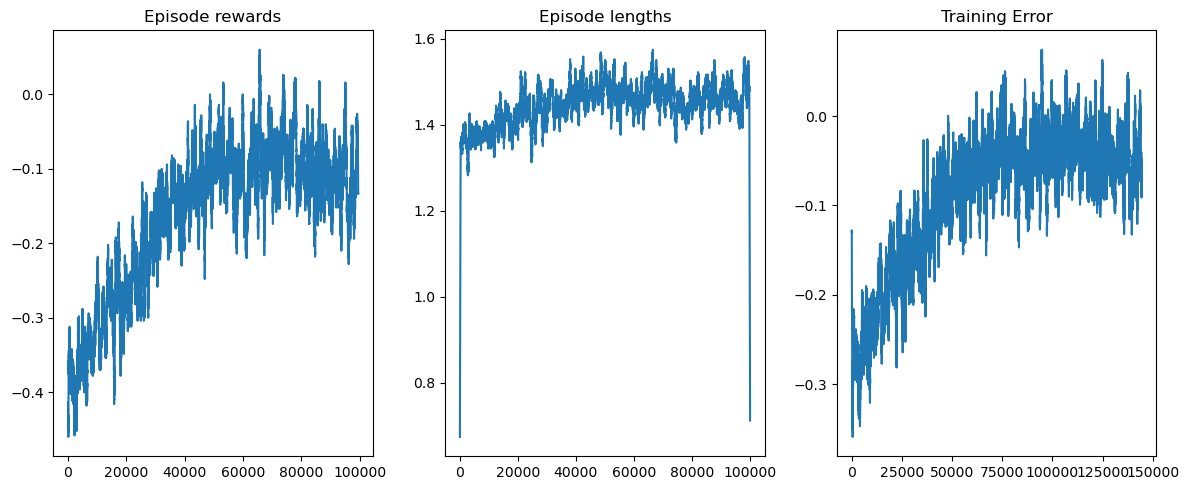

In [10]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

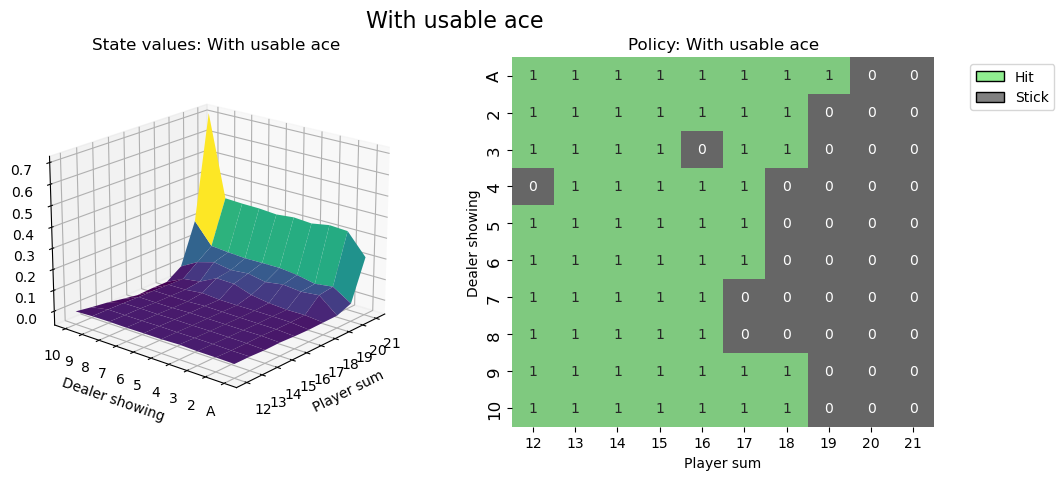

In [11]:
##Visualize Policy

def create_grids(agent,usable_ace=False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        np.arange(12,22),
        np.arange(1,11)
    )

    value = np.apply_along_axis(lambda obs: state_value[(obs[0], obs[1], usable_ace)],
                                axis=2, arr=np.dstack([player_count, dealer_count]))
    value_grid = player_count, dealer_count, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

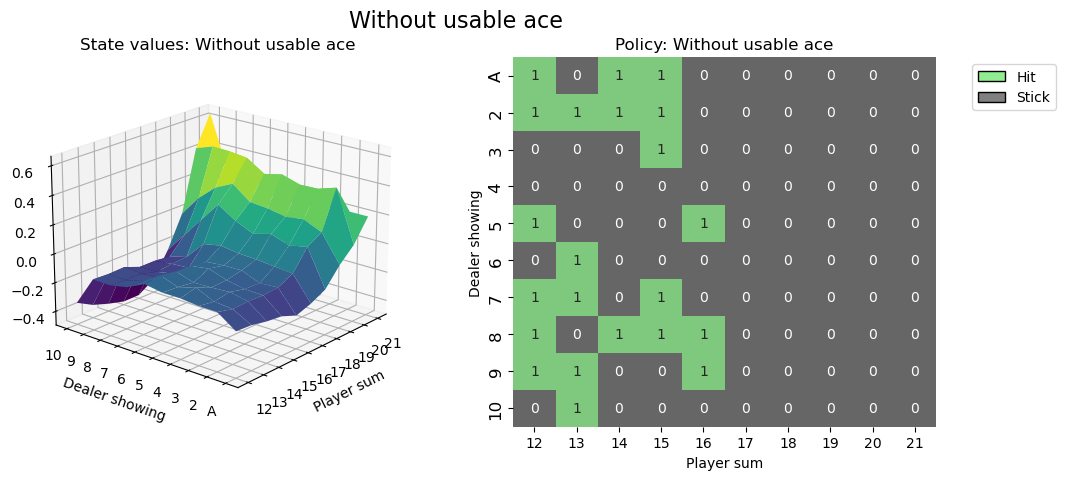

In [12]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()